# Topic Analysis

This notebook analyzes the commentedPool.json file from the 2025.04.05 ToPeraicaLiska folder to extract and analyze topics.

In [1]:
# Import required libraries
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# Define paths
DATA_DIR = Path('../2025.04.05 ToPeraicaLiska')
JSON_FILE = DATA_DIR / 'commentedPool.json'

# Check if file exists
if not JSON_FILE.exists():
    raise FileNotFoundError(f"File {JSON_FILE} not found")

logger.info(f"Reading JSON file: {JSON_FILE}")

INFO:__main__:Reading JSON file: ../2025.04.05 ToPeraicaLiska/commentedPool.json


In [40]:
def read_json_in_chunks_with_ids(file_path, chunk_size=1000, max_entries=2000):
    articles = []
    comments = []
    article_id_counter = 0
    entry_count = 0
    
    with open(file_path, 'r', encoding='utf-8') as f:
        # Read the file line by line
        current_entry = []
        bracket_count = 0
        
        for line in tqdm(f, desc="Reading JSON file"):
            if entry_count >= max_entries:
                break
                
            line = line.strip()
            if not line:
                continue
                
            # Count brackets in the line
            bracket_count += line.count('{') - line.count('}')
            current_entry.append(line)
            
            # If we've closed all brackets, we have a complete entry
            if bracket_count == 0 and current_entry:
                try:
                    entry_str = ''.join(current_entry)
                    # Remove trailing comma if present
                    if entry_str.endswith(','):
                        entry_str = entry_str[:-1]
                    entry = json.loads(entry_str)
                    
                    # Process article
                    article = entry['article']
                    article['article_id'] = article_id_counter
                    articles.append(article)
                    
                    # Process comments
                    for comment in entry['comments']:
                        comment['article_id'] = article_id_counter
                        comments.append(comment)
                    
                    article_id_counter += 1
                    entry_count += 1
                    
                    # Yield chunks if we've reached chunk_size
                    if len(articles) >= chunk_size:
                        yield articles, comments
                        articles = []
                        comments = []
                    
                    current_entry = []
                except json.JSONDecodeError:
                    current_entry = []
                    continue
    
    # Yield any remaining data
    if articles:
        yield articles, comments

In [43]:
# Then you would use it like this:
all_articles = []
all_comments = []

for article_chunk, comment_chunk in read_json_in_chunks_with_ids(JSON_FILE, max_entries=200000):
    all_articles.extend(article_chunk)
    all_comments.extend(comment_chunk)

# Create DataFrames
articles_df = pd.DataFrame(all_articles)
comments_df = pd.DataFrame(all_comments)

logger.info(f"Total number of articles: {len(articles_df)}")
logger.info(f"Total number of comments: {len(comments_df)}")

Reading JSON file: 15517824it [00:07, 2009285.61it/s]
INFO:__main__:Total number of articles: 10610
INFO:__main__:Total number of comments: 348047


In [44]:
# Display basic information
print("Articles DataFrame:")
print(f"Shape: {articles_df.shape}")
print("\nColumns:")
print(articles_df.columns.tolist())
print("\nFirst few rows:")
print(articles_df[['article_id', 'title']].head())

print("\n\nComments DataFrame:")
print(f"Shape: {comments_df.shape}")
print("\nColumns:")
print(comments_df.columns.tolist())
print("\nFirst few rows:")
print(comments_df[['article_id', 'title']].head())

# Verify the relationship
print("\nVerification:")
print(f"Total number of unique articles: {article_id_counter}")
print(f"Number of articles in articles_df: {len(articles_df)}")
print(f"Number of unique article_ids in comments_df: {comments_df['article_id'].nunique()}")

Articles DataFrame:
Shape: (10610, 11)

Columns:
['docId', 'docCode', 'docType', 'author', 'publishDate', 'url', 'title', 'content', 'attributes', 'docIdx', 'article_id']

First few rows:
   article_id                                              title
0           0      Soudci, kteří dali podmínku znásilňujícímu...
1           1  Opilec na elektrokoloběžce smetl v Brně na cho...
2           2  Český dobrodruh jde pěšky od Pacifiku k Atlant...
3           3  KVÍZ: Škoda Felicia slaví 30 let, jak dobře ji...
4           4  Jsem větší značka než Barrandov, řekl Soukup. ...


Comments DataFrame:
Shape: (348047, 13)

Columns:
['docId', 'docCode', 'docType', 'author', 'publishDate', 'url', 'title', 'content', 'attributes', 'docIdx', 'article_id', 'replyToAuthor', 'replyToDocId']

First few rows:
   article_id                                              title
0           0  Soudci, kteří dali podmínku znásilňujícímu otč...
1           0  Soudci, kteří dali podmínku znásilňujícímu otč...
2  

In [57]:
# Corrected parsing logic for the topic file
TOPICS_FILE = Path('../2025.04.05 ToPeraicaLiska/Topics/topicEVOC_artClusterText_KeyBERT_0.txt')

# Initialize structures for article-to-cluster mapping
article_id_to_cluster = {}
topic_article_to_cluster = {}  # For debugging
title_to_cluster = {}  # For title-based lookup

# Reset cluster columns in articles_df
articles_df['cluster_id'] = -1
articles_df['cluster_label'] = 'Unlabelled'

# Read entire file first to understand structure
with open(TOPICS_FILE, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Process the file structure correctly
current_cluster = None
current_label = None
i = 0

while i < len(lines):
    line = lines[i].strip()
    i += 1
    
    if not line or line.startswith('='):
        continue
    
    # New cluster section starts
    if line.startswith('cluster'):
        parts = line.split(':')
        cluster_info = parts[0].split()
        current_cluster = int(cluster_info[1])  # Explicitly convert to int
        current_label = parts[1].strip()
        print(f"Found cluster: {current_cluster} - {current_label}")
        
    # Article within current cluster
    elif line.startswith('** Article'):
        parts = line.split(':', 1)
        article_part = parts[0].strip()
        topic_article_id = int(article_part.split()[2])
        article_title = parts[1].strip()
        
        # Store mapping for debugging
        topic_article_to_cluster[topic_article_id] = (current_cluster, current_label)
        title_to_cluster[article_title] = (current_cluster, current_label)
        
        # Find this article in our dataset
        matching_rows = articles_df[articles_df['title'] == article_title]
        if not matching_rows.empty:
            our_article_id = matching_rows.iloc[0]['article_id']
            articles_df.loc[matching_rows.index, 'cluster_id'] = current_cluster
            articles_df.loc[matching_rows.index, 'cluster_label'] = current_label
            article_id_to_cluster[our_article_id] = (current_cluster, current_label)

# Now update comments_df based on corrected article clusters
comments_df['cluster_id'] = -1
comments_df['cluster_label'] = 'Unlabelled'

# Create a mapping of article_id to cluster info from the corrected articles_df
article_cluster_mapping = {}
for _, row in articles_df.iterrows():
    article_cluster_mapping[row['article_id']] = (row['cluster_id'], row['cluster_label'])

# Apply to comments
for idx, row in comments_df.iterrows():
    if row['article_id'] in article_cluster_mapping:
        cluster_id, cluster_label = article_cluster_mapping[row['article_id']]
        comments_df.at[idx, 'cluster_id'] = cluster_id
        comments_df.at[idx, 'cluster_label'] = cluster_label

# Verify the specific article
article_title = "Na nové dálnici D4 budou řidiči pod neustálým dohledem dvou stovek kamer a několika radarů"
print(f"\nChecking specific article: '{article_title[:50]}...'")

# 1. Check in our title-to-cluster mapping
if article_title in title_to_cluster:
    print(f"Topic file assigns it to cluster: {title_to_cluster[article_title][0]} - {title_to_cluster[article_title][1]}")
else:
    print("Article not found in topic file by title")

# 2. Check in articles_df
article_in_df = articles_df[articles_df['title'] == article_title]
if not article_in_df.empty:
    print(f"In articles_df: article_id={article_in_df.iloc[0]['article_id']}, cluster_id={article_in_df.iloc[0]['cluster_id']}, label={article_in_df.iloc[0]['cluster_label']}")
else:
    print("Article not found in articles_df")

# 3. Check comments for this article
if not article_in_df.empty:
    article_id = article_in_df.iloc[0]['article_id']
    jan_comments = comments_df[(comments_df['article_id'] == article_id) & (comments_df['author'] == 'Jan Novák')]
    if not jan_comments.empty:
        print(f"Jan Novák's comment for this article has cluster_id={jan_comments.iloc[0]['cluster_id']}, label={jan_comments.iloc[0]['cluster_label']}")
    else:
        print("No comments from Jan Novák for this article")

Found cluster: -1 - 12037 Unlabelled
Found cluster: 0 - 33 trumpovu mohl
Found cluster: 1 - 29 papež náboženským
Found cluster: 2 - 48 princezna svatby
Found cluster: 3 - 37 jihokorejskému zatčením
Found cluster: 4 - 38 severokorejští raket
Found cluster: 5 - 64 putinovo rusům
Found cluster: 6 - 34 požárům kalifornie
Found cluster: 7 - 34 nevidomí nepozornosti
Found cluster: 8 - 27 škvoreckého rusové
Found cluster: 9 - 23 aerolinkách cathay
Found cluster: 10 - 26 konzole videohry
Found cluster: 11 - 103 ghostrunneru maskotem
Found cluster: 12 - 38 pražském letadel
Found cluster: 13 - 93 brazílii miliardářkou
Found cluster: 14 - 21 demonstranti propalestinské
Found cluster: 15 - 42 titanic potopila
Found cluster: 16 - 134 sýrii teroristických
Found cluster: 17 - 80 slovenskou miloslav
Found cluster: 18 - 96 letěla nouzové
Found cluster: 19 - 39 aerolinek pasažérů
Found cluster: 20 - 28 vláda antimonopolního
Found cluster: 21 - 25 evropská emisím
Found cluster: 22 - 31 vědcům česká
Found

In [58]:
# Calculate and display statistics with all clusters (including -1) as valid
total_comments = len(comments_df)

print(f"\nCluster Assignment Statistics:")
print(f"Total comments: {total_comments}")
print(f"All comments have been assigned to clusters (including Unlabelled)")

# Calculate cluster distribution
cluster_distribution = comments_df['cluster_id'].value_counts().sort_index()
cluster_label_mapping = {}
for _, row in articles_df.iterrows():
    if row['cluster_id'] not in cluster_label_mapping:
        cluster_label_mapping[row['cluster_id']] = row['cluster_label']

# Ensure -1 is in the mapping
if -1 not in cluster_label_mapping:
    cluster_label_mapping[-1] = "Unlabelled"

print("\nDistribution of comments across clusters:")
for cluster_id, count in cluster_distribution.items():
    label = cluster_label_mapping.get(cluster_id, "Unknown")
    print(f"Cluster {cluster_id} ({label}): {count} comments ({count/len(comments_df)*100:.2f}%)")


Cluster Assignment Statistics:
Total comments: 348047
All comments have been assigned to clusters (including Unlabelled)

Distribution of comments across clusters:
Cluster -1 (12037 Unlabelled): 182243 comments (52.36%)
Cluster 0 (33 trumpovu mohl): 238 comments (0.07%)
Cluster 1 (29 papež náboženským): 62 comments (0.02%)
Cluster 2 (48 princezna svatby): 57 comments (0.02%)
Cluster 3 (37 jihokorejskému zatčením): 32 comments (0.01%)
Cluster 4 (38 severokorejští raket): 41 comments (0.01%)
Cluster 5 (64 putinovo rusům): 592 comments (0.17%)
Cluster 6 (34 požárům kalifornie): 12 comments (0.00%)
Cluster 7 (34 nevidomí nepozornosti): 175 comments (0.05%)
Cluster 9 (23 aerolinkách cathay): 55 comments (0.02%)
Cluster 10 (26 konzole videohry): 46 comments (0.01%)
Cluster 11 (103 ghostrunneru maskotem): 208 comments (0.06%)
Cluster 12 (38 pražském letadel): 557 comments (0.16%)
Cluster 13 (93 brazílii miliardářkou): 4390 comments (1.26%)
Cluster 14 (21 demonstranti propalestinské): 3 comme

In [59]:
# Group comments by user and find unique clusters per user
user_clusters = {}

# Process each comment to build the mapping
for _, comment in comments_df.iterrows():
    author = comment['author']
    cluster_id = comment['cluster_id']
    cluster_label = comment['cluster_label']
    
    # Initialize user entry if not exists
    if author not in user_clusters:
        user_clusters[author] = {
            'clusters': set(),  # Use a set to store unique clusters
            'cluster_details': {},  # Map clusters to their labels
            'comment_count': 0
        }
    
    # Add cluster to user's set
    user_clusters[author]['clusters'].add(cluster_id)
    user_clusters[author]['cluster_details'][cluster_id] = cluster_label
    user_clusters[author]['comment_count'] += 1

# Create DataFrame for analysis
user_data = []
for author, data in user_clusters.items():
    user_data.append({
        'author': author,
        'unique_clusters': len(data['clusters']),
        'clusters': list(data['clusters']),
        'cluster_labels': [data['cluster_details'][c] for c in data['clusters']],
        'comment_count': data['comment_count']
    })

user_cluster_df = pd.DataFrame(user_data)

# Sort by number of unique clusters (descending)
user_cluster_df = user_cluster_df.sort_values(by='unique_clusters', ascending=False)

# Display statistics
print(f"Total number of users: {len(user_cluster_df)}")
print("\nDistribution of users by number of clusters they post to:")
cluster_count_distribution = user_cluster_df['unique_clusters'].value_counts().sort_index()
for count, num_users in cluster_count_distribution.items():
    percentage = (num_users / len(user_cluster_df)) * 100
    print(f"Users posting to {count} different clusters: {num_users} ({percentage:.2f}%)")

# Show top users who post to the most clusters
print("\nTop 10 users who post to the most different clusters:")
top_users = user_cluster_df.head(10)
for idx, row in top_users.iterrows():
    print(f"User: {row['author']}")
    print(f"  Posts to {row['unique_clusters']} different clusters")
    print(f"  Total comments: {row['comment_count']}")
    
    # List the top 5 clusters (if they have more than 5)
    clusters_to_show = min(5, len(row['clusters']))
    if clusters_to_show < len(row['clusters']):
        print(f"  Top {clusters_to_show} clusters (out of {len(row['clusters'])}):")
    else:
        print(f"  Clusters:")
    
    for i in range(clusters_to_show):
        cluster_id = row['clusters'][i]
        label = row['cluster_labels'][i]
        print(f"    - Cluster {cluster_id}: {label}")
    print()

Total number of users: 47657

Distribution of users by number of clusters they post to:
Users posting to 1 different clusters: 22163 (46.51%)
Users posting to 2 different clusters: 8240 (17.29%)
Users posting to 3 different clusters: 4623 (9.70%)
Users posting to 4 different clusters: 2962 (6.22%)
Users posting to 5 different clusters: 1990 (4.18%)
Users posting to 6 different clusters: 1501 (3.15%)
Users posting to 7 different clusters: 1138 (2.39%)
Users posting to 8 different clusters: 846 (1.78%)
Users posting to 9 different clusters: 671 (1.41%)
Users posting to 10 different clusters: 520 (1.09%)
Users posting to 11 different clusters: 469 (0.98%)
Users posting to 12 different clusters: 330 (0.69%)
Users posting to 13 different clusters: 328 (0.69%)
Users posting to 14 different clusters: 251 (0.53%)
Users posting to 15 different clusters: 245 (0.51%)
Users posting to 16 different clusters: 207 (0.43%)
Users posting to 17 different clusters: 138 (0.29%)
Users posting to 18 differe

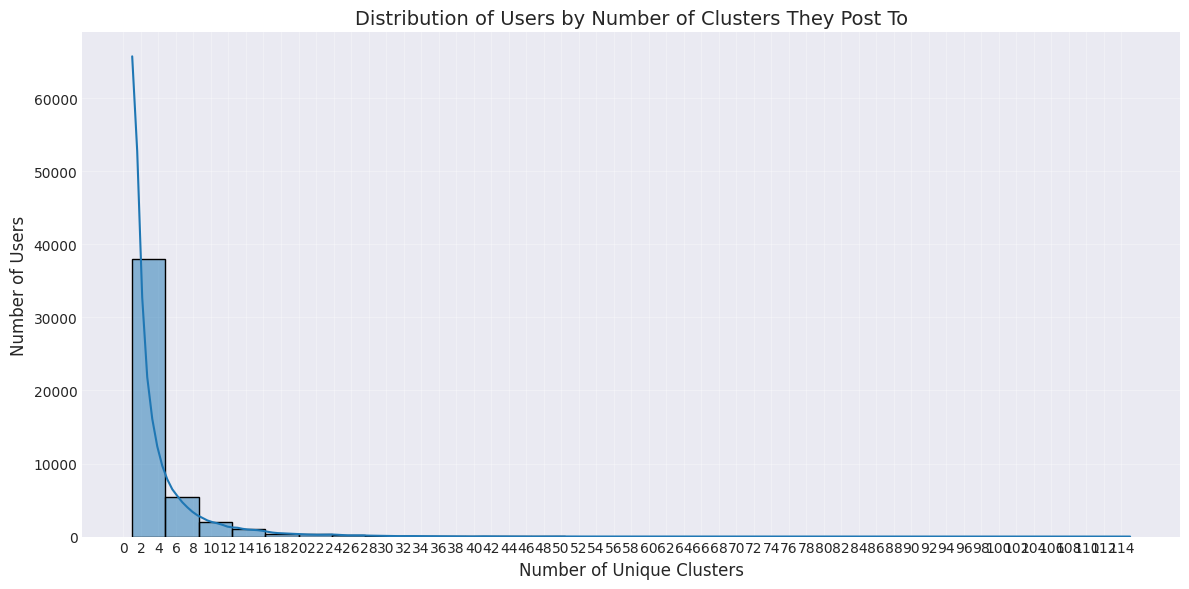

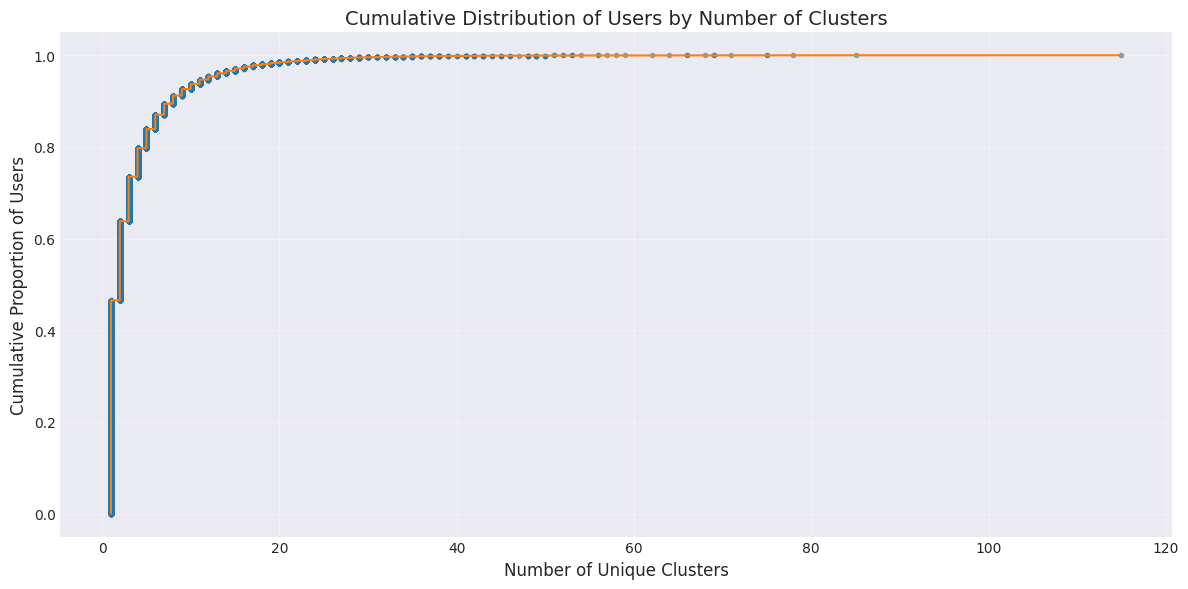

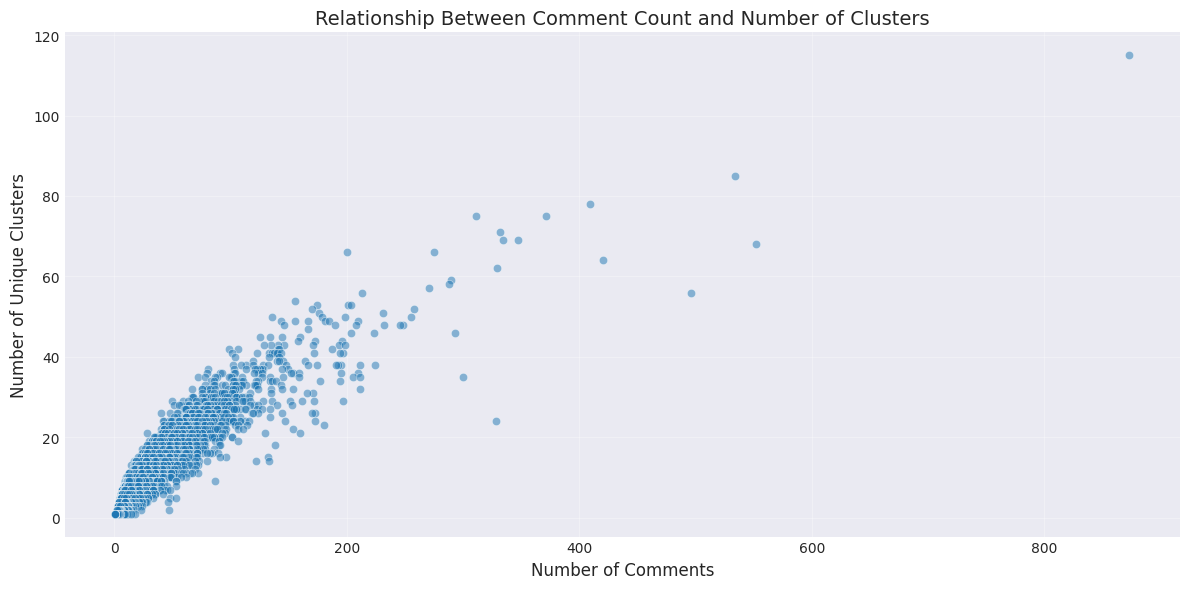

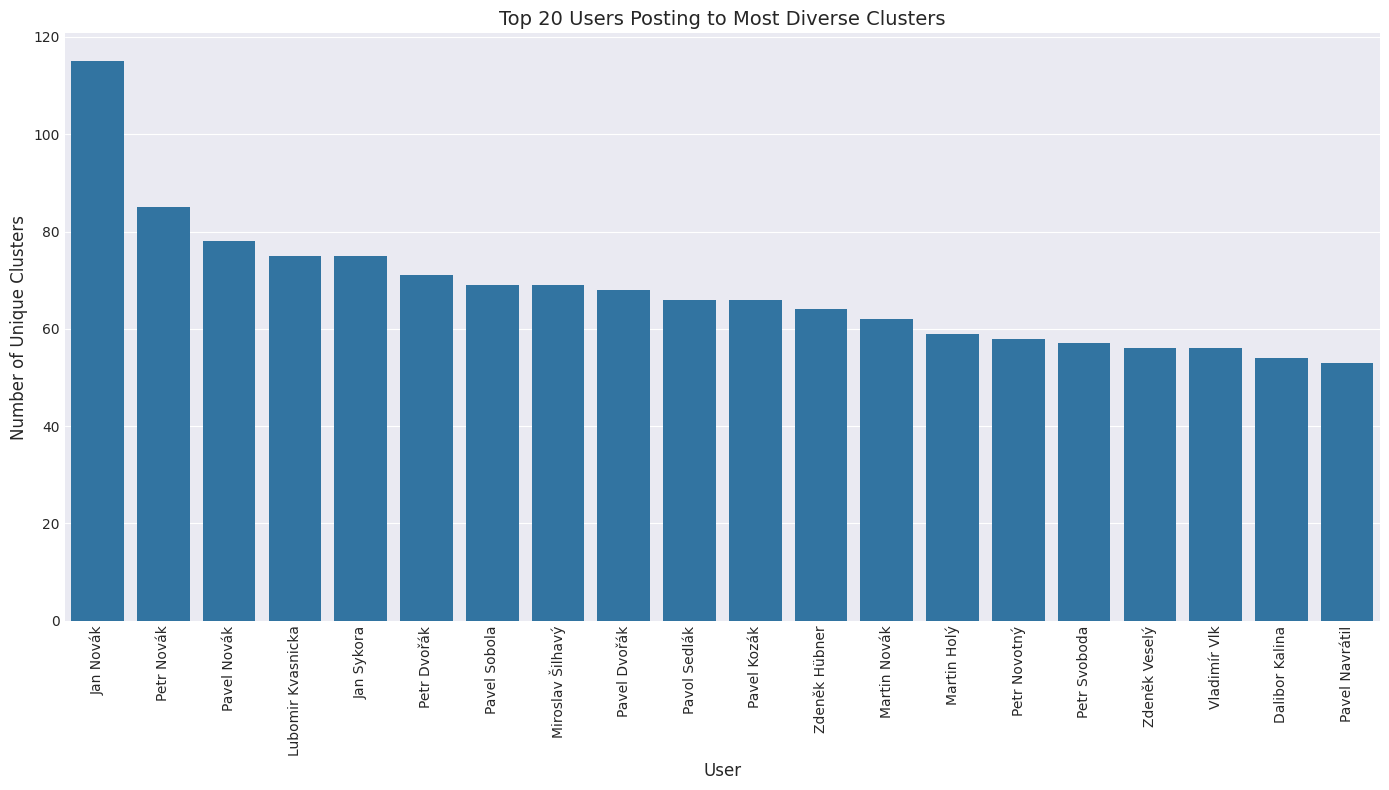

Summary Statistics for Unique Clusters per User:
count    47657.000000
mean         3.408712
std          4.716214
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        115.000000
Name: unique_clusters, dtype: float64

Percentage of users by number of clusters:
1 clusters: 46.51%
2 clusters: 17.29%
3 clusters: 9.70%
4 clusters: 6.22%
5 clusters: 4.18%
6 clusters: 3.15%
7 clusters: 2.39%
8 clusters: 1.78%
9 clusters: 1.41%
10 clusters: 1.09%
11 clusters: 0.98%
12 clusters: 0.69%
13 clusters: 0.69%
14 clusters: 0.53%
15 clusters: 0.51%
16 clusters: 0.43%
17 clusters: 0.29%
18 clusters: 0.25%
19 clusters: 0.24%
20 clusters: 0.18%
21 clusters: 0.16%
22 clusters: 0.14%
23 clusters: 0.14%
24 clusters: 0.17%
25 clusters: 0.10%
26 clusters: 0.09%
27 clusters: 0.11%
28 clusters: 0.07%
29 clusters: 0.07%
30 clusters: 0.04%
31 clusters: 0.03%
32 clusters: 0.04%
33 clusters: 0.04%
34 clusters: 0.03%
35 clusters: 0.03%
36 clusters: 0.03%
37 clusters: 0.0

In [60]:
# Import visualization libraries if not already imported
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Figure 1: Distribution of users by number of clusters
plt.figure(figsize=(12, 6))
sns.histplot(data=user_cluster_df, x='unique_clusters', kde=True, bins=30)
plt.title('Distribution of Users by Number of Clusters They Post To', fontsize=14)
plt.xlabel('Number of Unique Clusters', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(range(0, max(user_cluster_df['unique_clusters'])+1, 2))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Cumulative distribution function (CDF)
plt.figure(figsize=(12, 6))
# Sort values for CDF
sorted_values = np.sort(user_cluster_df['unique_clusters'].values)
# Get y values for CDF
yvals = np.arange(1, len(sorted_values)+1) / float(len(sorted_values))
# Plot CDF
plt.plot(sorted_values, yvals, marker='.', linestyle='none', alpha=0.5)
plt.plot(sorted_values, yvals, linestyle='-')
plt.title('Cumulative Distribution of Users by Number of Clusters', fontsize=14)
plt.xlabel('Number of Unique Clusters', fontsize=12)
plt.ylabel('Cumulative Proportion of Users', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 3: Scatter plot of unique clusters vs. comment count
plt.figure(figsize=(12, 6))
plt.scatter(user_cluster_df['comment_count'], user_cluster_df['unique_clusters'], 
            alpha=0.5, edgecolor='w', linewidth=0.5)
plt.title('Relationship Between Comment Count and Number of Clusters', fontsize=14)
plt.xlabel('Number of Comments', fontsize=12)
plt.ylabel('Number of Unique Clusters', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 4: Top 20 users with most diverse posting patterns
top_20_users = user_cluster_df.head(20)
plt.figure(figsize=(14, 8))
sns.barplot(data=top_20_users, x='author', y='unique_clusters')
plt.title('Top 20 Users Posting to Most Diverse Clusters', fontsize=14)
plt.xlabel('User', fontsize=12)
plt.ylabel('Number of Unique Clusters', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Unique Clusters per User:")
print(user_cluster_df['unique_clusters'].describe())

# Compute percentage of users by cluster count
cluster_counts = user_cluster_df['unique_clusters'].value_counts(normalize=True).sort_index() * 100
print("\nPercentage of users by number of clusters:")
for clusters, percentage in cluster_counts.items():
    print(f"{clusters} clusters: {percentage:.2f}%")

In [61]:
# Get article examples for the top cluster-diverse users (3 clusters per user)

# Get the 5 most diverse users (those who post to the most clusters)
top_users = user_cluster_df.head(5)['author'].tolist()

article_examples = {}

# For each top user, find one example article from each cluster they post to
for user in top_users:
    # Filter comments for this user
    user_comments = comments_df[comments_df['author'] == user]
    
    # Group by cluster_id and get one example article from each
    clusters = {}
    for cluster_id in user_comments['cluster_id'].unique():
        # Get one comment from this cluster
        comment = user_comments[user_comments['cluster_id'] == cluster_id].iloc[0]
        
        # Get the article information
        article_id = comment['article_id']
        article = articles_df[articles_df['article_id'] == article_id].iloc[0]
        
        clusters[int(cluster_id)] = {
            'article_title': article['title'],
            'cluster_label': comment['cluster_label']
        }
    
    article_examples[user] = clusters

# Display the results
for user, clusters in article_examples.items():
    print(f"User: {user}")
    print(f"Posted across {len(clusters)} clusters. Example articles (3 of {len(clusters)}):")
    
    # Get user's cluster count from our earlier dataframe
    user_data = user_cluster_df[user_cluster_df['author'] == user].iloc[0]
    
    # Sort clusters by cluster ID
    sorted_clusters = sorted(clusters.items())
    
    # Print exactly 3 examples (or fewer if user has posted to fewer clusters)
    for i, (cluster_id, data) in enumerate(sorted_clusters[:3]):
        print(f"  Cluster {cluster_id} ({data['cluster_label']}):")
        print(f"    Article: {data['article_title']}")
    
    print(f"  Total comments by user: {user_data['comment_count']}")
    print()

User: Jan Novák
Posted across 115 clusters. Example articles (3 of 115):
  Cluster -1 (12037 Unlabelled):
    Article: Soudci, kteří dali podmínku znásilňujícímu...
  Cluster 3 (37 jihokorejskému zatčením):
    Article: Jihokorejský prezident Jun Sok-jol opustil vazební věznici
  Cluster 7 (34 nevidomí nepozornosti):
    Article: Veřejnoprávní média nepotřebují víc peněz, potřebují definovat, co je jejich práce
  Total comments by user: 873

User: Petr Novák
Posted across 85 clusters. Example articles (3 of 85):
  Cluster -1 (12037 Unlabelled):
    Article: Žena v Německu pobodala v autobuse šest lidí
  Cluster 0 (33 trumpovu mohl):
    Article: Jak by mohl vypadat Okamurův výslech na policii?
  Cluster 12 (38 pražském letadel):
    Article: OK je K. O. Loučení s ČSA po posledním přistání v historii připomínalo pohřeb
  Total comments by user: 534

User: Pavel Novák
Posted across 78 clusters. Example articles (3 of 78):
  Cluster -1 (12037 Unlabelled):
    Article: Žena v Německu pobod